In [1]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import scipy
import scipy.ndimage as ndi
from skimage import (
    color, filters, exposure, measure, morphology, transform, util)
from segmentflow import segment, view
from tqdm.notebook import tqdm
%load_ext autoreload
%autoreload 2

## Load images

In [2]:
imgs_path = Path('data/angler-fish-118531')
# merge_file_path = Path('supporting/merge-0.2x-15msd.txt')
merge_file_path = None
save_dir_path = Path('results/')
scale = None
# scale = 0.20
# msd = 15
# suffix = '-skull_jaw_merged'
# suffix = ''

In [3]:
def load_rescaled_images(
    imgs_path, scale, file_suffix=".tif", convert_to_unit8=False
):
    imgs_path = Path(imgs_path)
    img_path_list = [
            path for path in imgs_path.glob(f'*{file_suffix}')]
    img0 = iio.imread(img_path_list[0])
    img0 = transform.rescale(img0, scale, anti_aliasing=False)
    imgs = np.zeros(
        (len(img_path_list) // int(1/scale) + 1, img0.shape[0], img0.shape[1]))
    if convert_to_unit8:
        imgs = imgs.astype(np.uint8)
    img_n_list = list(range(0, len(img_path_list), int(1/scale)))
    for new_i, og_i in tqdm(enumerate(img_n_list)):
        img = iio.imread(img_path_list[og_i])
        img_rs = transform.rescale(img, scale, anti_aliasing=False)
        if convert_to_unit8:
            imgs[new_i, ...] = util.img_as_ubyte(img_rs)
        else:
            imgs[new_i, ...] = img_rs
    return imgs

Loading images...
--> Images loaded as 3D array:  (2022, 800, 510)
Data type:  uint8
--> Plotting images: [   0  252  505  757 1010 1263 1515 1768 2021]


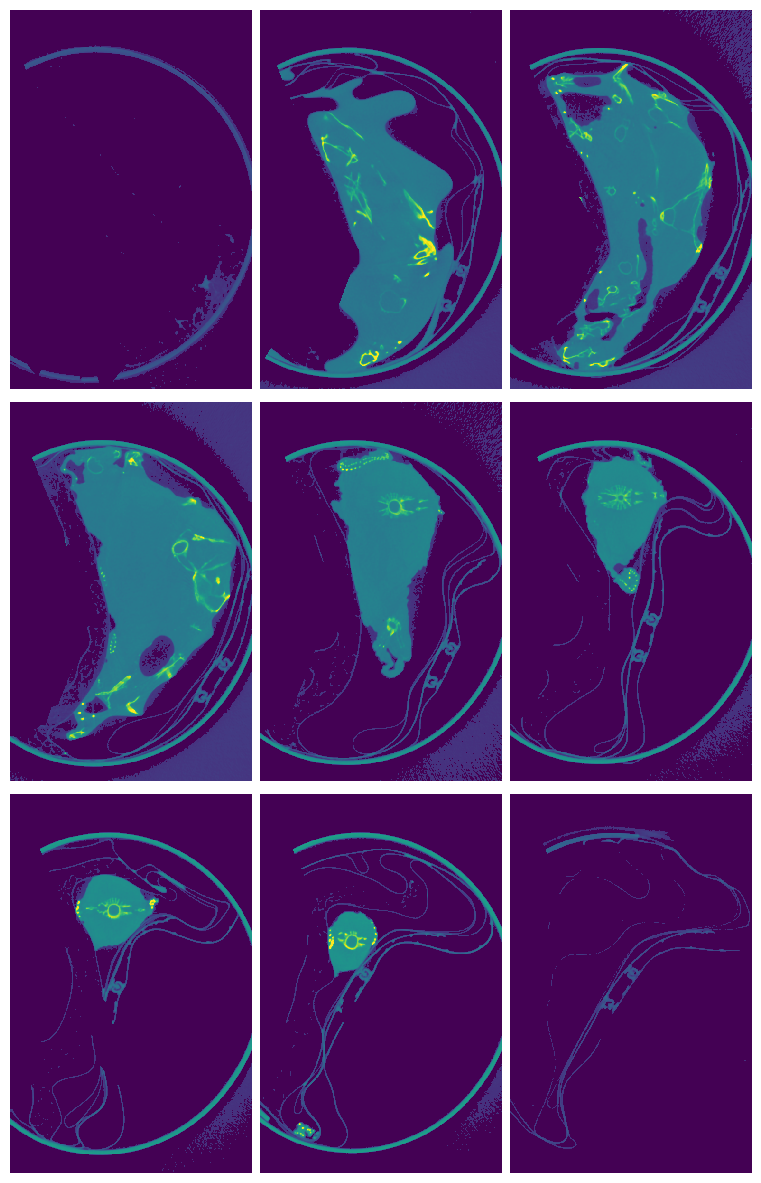

In [12]:
if scale is not None:
    imgs = load_rescaled_images(
        imgs_path, scale, file_suffix='.tif', convert_to_unit8=True)
else:
    imgs = segment.load_images(imgs_path, file_suffix='.tif')
imgs = filters.median(imgs)
imgs = util.img_as_ubyte(imgs)
print('Data type: ', imgs.dtype)
fig, axes = view.plot_slices(
    imgs,
    nslices=9,
    print_slices=True,
    imgs_per_row=3,
    fig_w=7.5,
    dpi=100
)

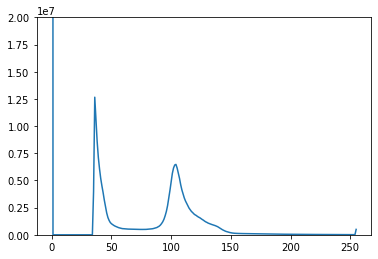

In [7]:
hist, bins_centers = exposure.histogram(imgs)
fig, ax = plt.subplots()
ax.plot(bins_centers, hist)
ax.set_ylim([0, 2e7])
plt.show()

## Semantic seg

--> Plotting images: [   0  252  505  757 1010 1263 1515 1768 2021]


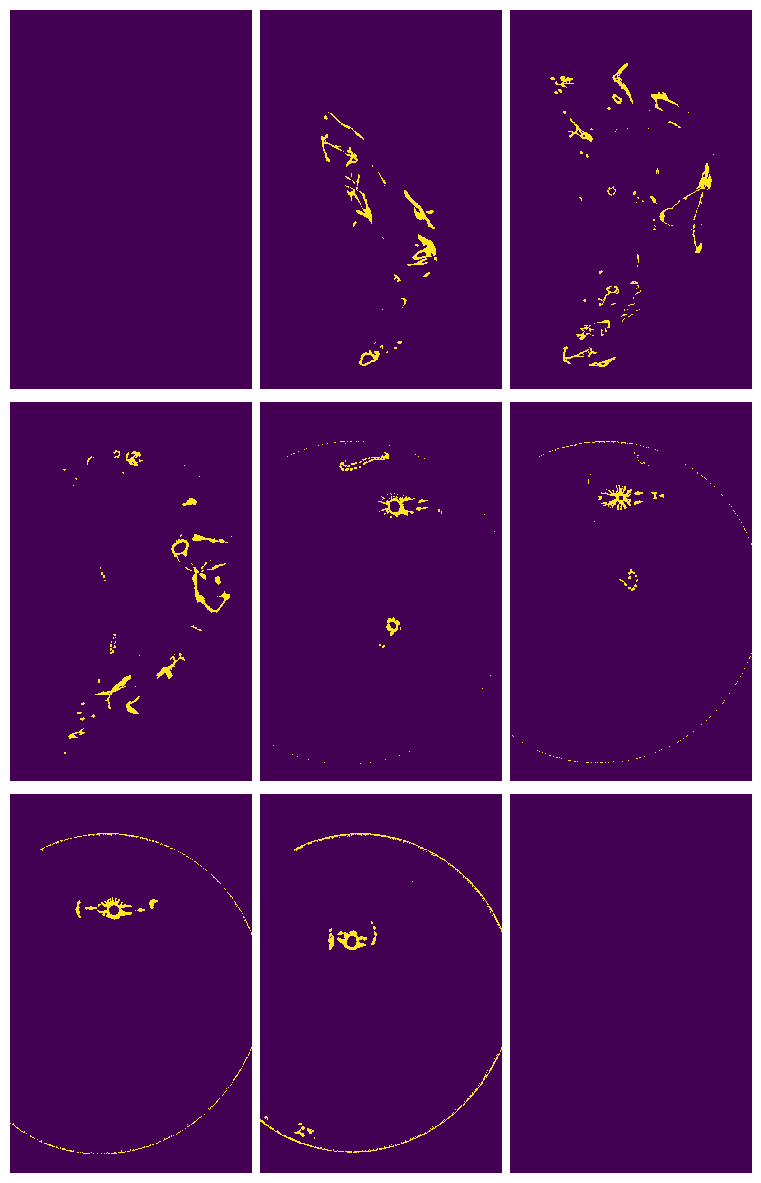

In [11]:
thresholds = [140]
imgs_semantic = segment.isolate_classes(imgs, thresholds)
fig, axes = view.plot_slices(
    imgs_semantic,
    nslices=9,
    print_slices=True,
    imgs_per_row=3,
    fig_w=7.5,
    dpi=100
)

In [21]:
pts = np.array(np.nonzero(imgs_semantic))
pts.shape

(3, 1849583)

## Clean image

--> Plotting images: [  0  54 109 163 218 273 327 382 437]


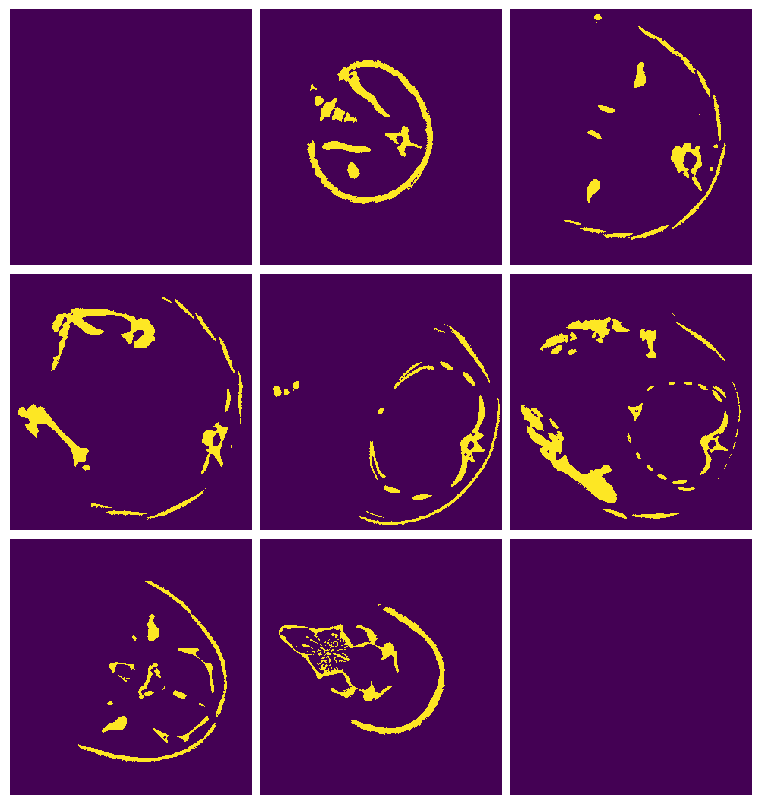

In [22]:
imgs_cleaned = morphology.binary_closing(imgs_semantic)
imgs_cleaned = ndi.binary_fill_holes(imgs_cleaned)
imgs_cleaned = morphology.remove_small_objects(imgs_cleaned, 10)
fig, axes = view.plot_slices(
    imgs_cleaned,
    nslices=9,
    print_slices=True,
    imgs_per_row=3,
    fig_w=7.5,
    dpi=100
)

## Make shell

--> Plotting images: [  0  54 109 163 218 273 327 382 437]


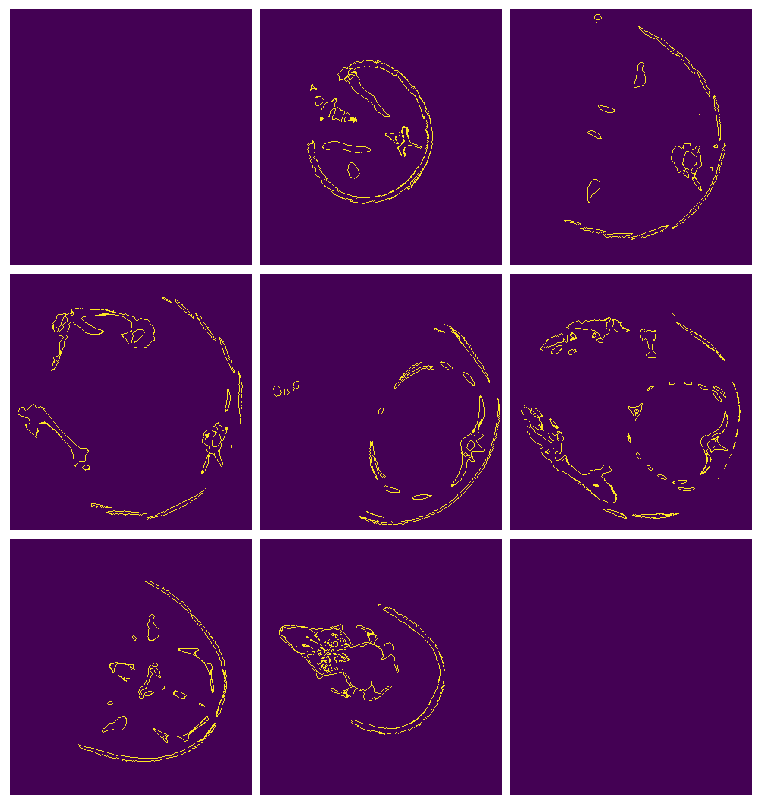

In [23]:
imgs_ero = morphology.binary_erosion(imgs_cleaned)
imgs_shell = np.logical_xor(imgs_cleaned, imgs_ero)
fig, axes = view.plot_slices(
    imgs_shell,
    nslices=9,
    print_slices=True,
    imgs_per_row=3,
    fig_w=7.5,
    dpi=100
)

In [24]:
pts = np.array(np.nonzero(imgs_shell))
print(pts.shape)
df = pd.DataFrame(pts.T, columns=['z', 'y', 'x'])
df.head()

(3, 780313)


,z,y,x
0,2,148,138
1,2,152,141
2,3,145,135
3,3,145,137
4,3,146,134


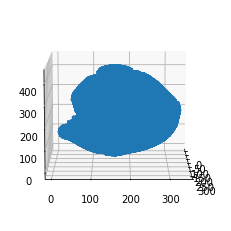

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df['x'].to_numpy(), df['y'].to_numpy(), df['z'].to_numpy(), s=1)
ax.view_init(elev=10, azim=0)

## Segment

Segmenting images...
--> Segmentation complete. 333 particle(s) segmented.
Merging the following regions:
    [303, 301, 307, 308, 332, 331, 333, 330, 314, 315, 312, 327, 328, 325, 320, 319, 311, 288, 289]
--> 315 region(s) after merge.
--> Plotting images: [  0  54 109 163 218 273 327 382 437]


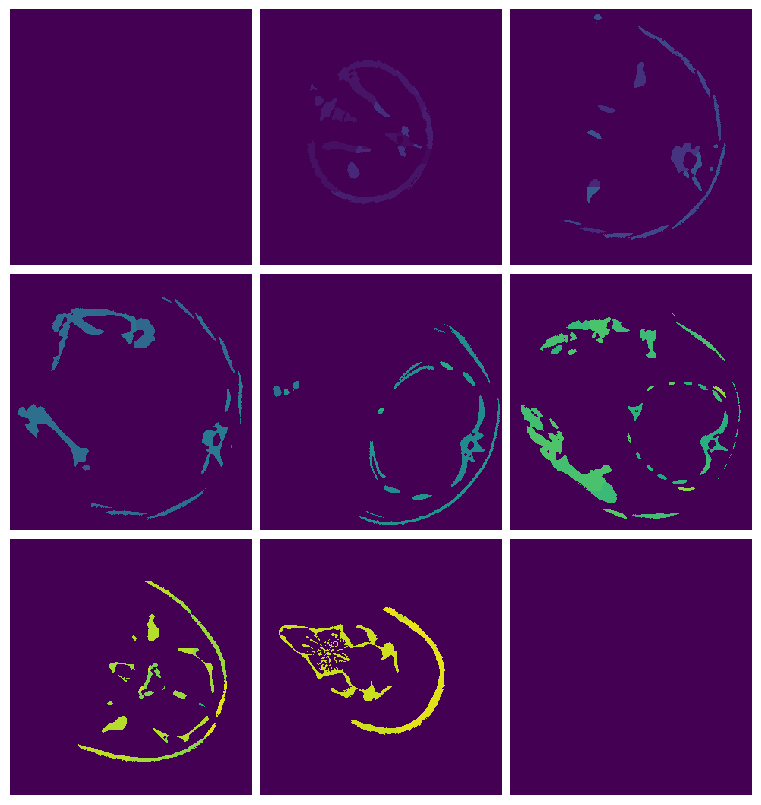

In [26]:
imgs_seg = segment.watershed_segment(imgs_cleaned, min_peak_distance=msd)
if merge_file_path is not None:
    imgs_seg = segment.manual_merge(imgs_seg, merge_file_path)
fig, axes = view.plot_slices(
    imgs_seg,
    nslices=9,
    print_slices=True,
    imgs_per_row=3,
    fig_w=7.5,
    dpi=100
)

In [27]:
np.unique(imgs_seg).shape

(316,)

### Save meshes

In [28]:
segment.save_as_stl_files(
    imgs_seg,
    save_dir_path,
    f'armadillo-{scale}x-{msd}msd{suffix}'
)


Generating surface meshes...
Surface mesh not created for particle 120. Particle likely too small. Error:  No surface found at the given iso value.
Surface mesh not created for particle 147. Particle likely too small. Error:  No surface found at the given iso value.
Surface mesh not created for particle 166. Particle likely too small. Error:  No surface found at the given iso value.
Surface mesh not created for particle 173. Particle likely too small. Error:  No surface found at the given iso value.
--> 311 STL file(s) written!
